In [88]:
import torch
import matplotlib.pyplot as plt
from torch_geometric.data import Data
import seaborn as sns
from torch_geometric.utils import  scatter

from torch_geometric.nn.pool import radius_graph
from models.util import rotate
from torch_geometric.loader import DataLoader

from models.model import RotTetrisModel, InvTetrisModel

colors = sns.color_palette("Set1")
col = []
for c in colors[:7]:
    l_ = list(c)
    l_.append(0.7)
    col.append(tuple(l_))


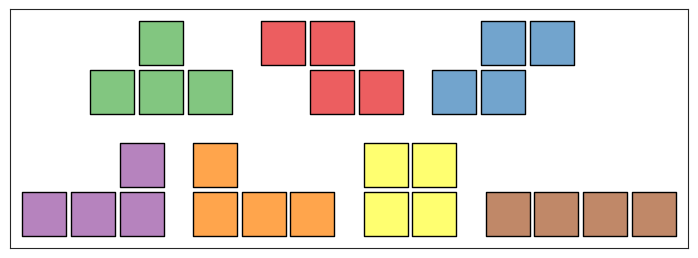

In [89]:
# We create the tetris blocks

block1=torch.tensor([[1.,0.],[2,0], [1.,1.], [0.,1.]])
block2=torch.tensor([[1.,0.],[2,0], [3,0], [4,0]]) 
block3=torch.tensor([[0.,0.],[1,0], [2,0], [1,1]])
block4=torch.tensor([[0.,0.],[1,0], [2,0], [2,1]])
block5=torch.tensor([[0.,0.],[1,0], [2,0], [0,1]])
block6=torch.tensor([[0.,0.],[1,0], [0,1], [1,1]])
block7=torch.tensor([[1.,0.],[2,0], [2.,1.], [3.,1.]])
import seaborn as sns
alpha = 0.7

sns.set_style("white")
sns.set_palette("Set1")
training_data = [block1,block2, block3, block4, block5, block6, block7]

a = .4
b =2.5

colors = sns.color_palette("Set1")
col = []
for c in colors[:7]:
    l_ = list(c)
    l_.append(0.7)
    col.append(tuple(l_))

#colors = [tuple(list(c).append(0.7) )for c in colors[:7]]
fig, ax = plt.subplots(1,1,figsize=(8.75,3.1))

ax.scatter(block1[:,0] + a , block1[:,1], marker = "s",s = 1000,facecolor = col[0],edgecolors= "black" )
ax.scatter(block7[:,0]+a + 2.5, block7[:,1], marker = "s",s = 1000 ,facecolor = col[1],edgecolors= "black" )
ax.scatter(block3[:,0]+a  -3.5, block3[:,1], marker = "s",s = 1000,facecolor = col[2] ,edgecolors= "black" )
ax.scatter(block4[:,0]  -4.5, block4[:,1]-b, marker = "s",s = 1000,facecolor = col[3] ,edgecolors= "black")
ax.scatter(block5[:,0] -1 , block4[:,1]-b, marker = "s",s = 1000,facecolor = col[4] ,edgecolors= "black")
ax.scatter(block6[:,0] + 2.5  , block6[:,1]-b, marker = "s",facecolor = col[5],s = 1000 ,edgecolors= "black")
ax.scatter(block2[:,0] + 4  , block2[:,1]-b, marker = "s",facecolor = col[6],s = 1000 ,edgecolors= "black")

ax.set_xlim(-5.2,8.7)
ax.set_ylim(-3.2,1.7)
ax.set_yticks([])
ax.set_xticks([]);


In [90]:
# We create a function that derives the test accuracy
def get_test_error(test_loader, model):
    
    preds = []
    trues = []
    neg_losses = []
    crit  = torch.nn.NLLLoss()

    for data in test_loader:
        pos = data.pos
        mean = scatter(pos, data.batch, dim=0, reduce ='mean')
        pos = pos - mean[data.batch]
        out = model(pos = pos, edge_index= data.edge_index,batch = data.batch)
        pred = torch.argmax(out, dim = 1)
        preds.append(pred.detach())
        trues.append(data.y)
        neg_losses.append(crit(out, data.y).item())

    preds = torch.cat(preds)
    trues = torch.cat(trues)

    correct = preds == trues
    acc_ =sum(correct)/len(correct)
    nll = sum(neg_losses)/len(neg_losses)
    return acc_,nll

In [91]:
# We create train and test data

y = 0
data_list = []
for d in training_data:
    edge_index = radius_graph(d, 5)
    data_list.append(Data(pos=d, edge_index=edge_index, y = y))
    y = y +1
train_loader = DataLoader(data_list, batch_size=len(data_list))

torch.manual_seed(33)
test_data = []
for i in range(100):
    for d in data_list:
        pos = d.pos
        mean = pos.mean()
        pos_ = pos - mean
        pos_ = rotate(torch.randn(1).item(), pos_)
        test_data.append(Data(pos=pos_, edge_index=d.edge_index, y = d.y))
test_loader = DataLoader(test_data, batch_size=32)

In [93]:
# We train the non-equivariant GNN

criterion = torch.nn.CrossEntropyLoss()
from torch_geometric.utils import  scatter
model_inv = InvTetrisModel(n_classes = 7, n_scalars=16, num_layers=2)
optim = torch.optim.Adam(model_inv.parameters(), lr=1e-3)
losses = []
test_error_inv = []
for epoch in range(100):
    for data in train_loader:
        pos = data.pos
        mean = scatter(pos, data.batch, dim=0, reduce ='mean')
        pos = pos - mean[data.batch]
        out = model_inv(pos = data.pos, edge_index= data.edge_index,batch = data.batch)
        loss = criterion(out,data.y)
        optim.zero_grad()
        loss.backward()
        optim.step()
        losses.append(loss.item())
        test_error_inv.append(get_test_error(test_loader, model_inv))
test_error_inv = list(zip(*test_error_inv))

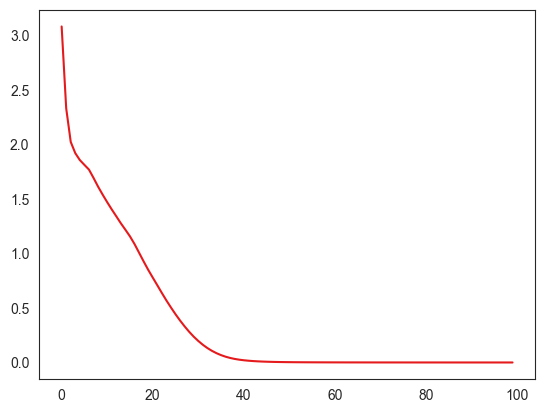

In [94]:
# We train the SE(2)-equivariant GNN

criterion = torch.nn.CrossEntropyLoss()
from torch_geometric.utils import  scatter
model_rot = RotTetrisModel(n_classes = 7, n_scalars=3, num_layers=2)

optim = torch.optim.Adam(model_rot.parameters(), lr=1e-3)
losses = []
test_error_rot = []

for epoch in range(100):
    for data in train_loader:
        pos = data.pos
        mean = scatter(pos, data.batch, dim=0, reduce ='mean')
        pos = pos - mean[data.batch]
        out = model_rot(pos = data.pos, edge_index= data.edge_index,batch = data.batch)
        loss = criterion(out,data.y)
        optim.zero_grad()
        loss.backward()
        optim.step()
        losses.append(loss.item())
        test_error_rot.append(get_test_error(test_loader, model_rot))

plt.plot(losses)
test_error_rot = list(zip(*test_error_rot))


Text(0, 0.5, 'Number of epochs')

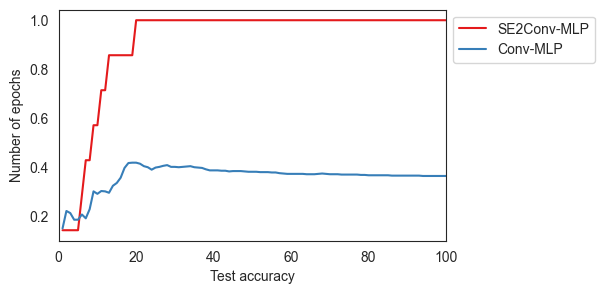

In [95]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
alpha = 0.7
colors = sns.color_palette("Set1")

sns.set_style("white")
sns.set_palette("Set1")
model_types = [r"$1\times 2\pi$", r"Rot $2\times \pi$", r"Rot $4 \times \pi/2$", r"Rot $8 \times \pi/4$"]
ind = np.arange(len(model_types))


f,ax = plt.subplots(1,1, figsize =(5,3), sharey=True)
ax.plot(range(1,101),test_error_rot[0], label = r"SE2Conv-MLP")

ax.plot(range(1,101),test_error_inv[0], label = r"Conv-MLP")


ax.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlim(0,100)
plt.xlabel("Test accuracy")
plt.ylabel("Number of epochs");
